In [1]:
"""
This code performs simple pinn training on a undamped, single DOF spring-mass system.
mx'' + kx = 0
"""
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
class SpringMassSystem:
    def __init__(self, m, k, x0, v0, device):
        self.m = torch.tensor(m, dtype=torch.float32).to(device)
        self.k = torch.tensor(k, dtype=torch.float32).to(device)
        self.x0 = torch.tensor(x0, dtype=torch.float32).to(device)
        self.v0 = torch.tensor(v0, dtype=torch.float32).to(device)
        self.omega = torch.sqrt(self.k/self.m).to(device)
        self.phi = torch.atan2(-1 * self.v0, self.x0).to(device)
        self.loss_module = torch.nn.MSELoss()
        self.device = device

    def ground_truth_forward(self, t):
        """
        generate ground truth solution
        x = x0 * cos(omega * t + phi), where
        omega = sqrt(k/m)
        phi = atan2(-v0/x0)
        """
        x = self.x0 * torch.cos(self.omega * t + self.phi)
        return x

    def error_forward(self, model, t):
        x = model(t)
        x_gt = self.ground_truth_forward(t)
        loss = self.loss_module(x, x_gt)
        return loss
    
    def ODE_loss_forward(self, x, t):
        dxdt = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
        d2xdt2 = torch.autograd.grad(dxdt, t, grad_outputs=torch.ones_like(dxdt), create_graph=True)[0]
        residual = self.m * d2xdt2 + self.k * x
        loss = torch.mean(residual**2)
        return loss

    def x0_loss_forward(self, model):
        t0 = torch.zeros(100, 1, requires_grad=False).to(self.device)
        x0 = model(t0)
        loss = self.loss_module(x0, self.x0)
        return loss

    def v0_loss_forward(self, model):
        t = torch.zeros(100, 1, requires_grad=True).to(self.device)
        x0 = model(t)
        v0 = torch.autograd.grad(x0, t, grad_outputs=torch.ones_like(x0), create_graph=True)[0]
        loss = self.loss_module(v0, self.v0)
        return loss
    
    def x1_loss_forward(self, model):
        t = 5 * torch.ones(100, 1, requires_grad=True).to(self.device)
        x1 = model(t)
        v1 = torch.autograd.grad(x1, t, grad_outputs=torch.ones_like(x1), create_graph=True)[0]
        x1_gt = self.ground_truth_forward(t)
        loss = self.loss_module(x1, x1_gt)
        return loss
        

class PINN(torch.nn.Module):
    def __init__(self, input_dim=1, output_dim=1, hidden_dim=16, depth=3):
        super(PINN, self).__init__()
        layers = []
        for i in range(depth):
            layers.append(torch.nn.Linear(input_dim if i == 0 else hidden_dim, hidden_dim))
            # layers.append(torch.nn.BatchNorm1d(hidden_dim))
            layers.append(torch.nn.Tanh())
        layers.append(torch.nn.Linear(hidden_dim, output_dim))
        self.net = torch.nn.Sequential(*layers)
        
    def forward(self, t):
        return self.net(t)

In [3]:
# conf
m = 1
k = 1
x0 = 1
v0 = 0.25
T = 50
device = torch.device('cuda:0')
model = PINN(1, 1, 128, 3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.5)
spring_mass_system = SpringMassSystem(m, k, x0, v0, device)
epochs = 50000
use_sparse_obs = True
t_sparse = T * torch.rand(10, 1, requires_grad=False).to(device)
gt_sparse = spring_mass_system.ground_truth_forward(t_sparse)

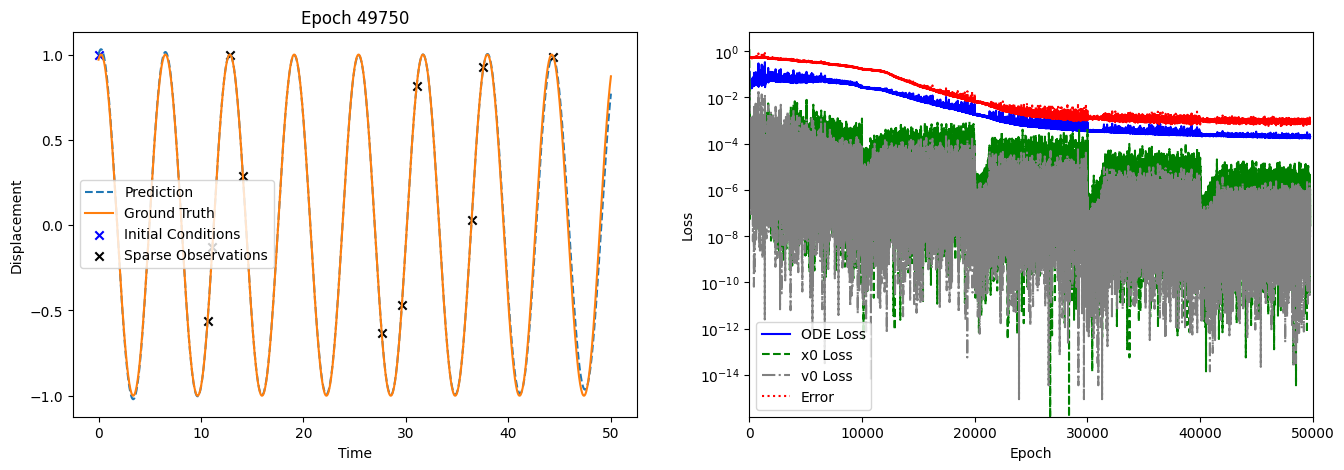

epoch 49751:, ode_loss: 0.00019829477241728455, x0_loss: 2.253319308920254e-07, v0_loss: 1.315471251928102e-07, error: 0.0010108437854796648
epoch 49752:, ode_loss: 0.00018953612016048282, x0_loss: 3.2898884683163487e-07, v0_loss: 7.624143449902476e-08, error: 0.0009964376222342253
epoch 49753:, ode_loss: 0.00018780477694235742, x0_loss: 6.865553103807542e-08, v0_loss: 2.2920687570149312e-10, error: 0.0009106501238420606
epoch 49754:, ode_loss: 0.00020057143410667777, x0_loss: 4.266797475338535e-07, v0_loss: 3.405352799745742e-08, error: 0.0009351199842058122
epoch 49755:, ode_loss: 0.00019345630425959826, x0_loss: 2.2418134904000908e-08, v0_loss: 5.441152595153653e-08, error: 0.0008816528134047985
epoch 49756:, ode_loss: 0.00018540718883741647, x0_loss: 2.6214796999823875e-09, v0_loss: 2.589928271845565e-10, error: 0.0008847788558341563
epoch 49757:, ode_loss: 0.00019971119763795286, x0_loss: 1.9697279185493244e-07, v0_loss: 4.0084845664978275e-08, error: 0.0009248723508790135
epoch 4

In [4]:
ode_loss_, x0_loss_, v0_loss_, error_ = [], [], [], []
for epoch in range(epochs):
    optimizer.zero_grad()
    t = T * torch.rand(10000, 1, requires_grad=True).to(device)
    x = model(t)
    ode_loss = spring_mass_system.ODE_loss_forward(x, t)
    x0_loss = spring_mass_system.x0_loss_forward(model)
    v0_loss = spring_mass_system.v0_loss_forward(model)
    error = spring_mass_system.error_forward(model, t)

    # add sparse observation for long-range prediction, if required
    if use_sparse_obs:
        loss_sparse_obs = spring_mass_system.error_forward(model, t_sparse)
    else:
        loss_sparse_obs = torch.tensor(0.0).to(device)

    loss = ode_loss + 1 * x0_loss + 1 * v0_loss + loss_sparse_obs
    # record losses
    ode_loss_.append(ode_loss.item())
    x0_loss_.append(x0_loss.item())
    v0_loss_.append(v0_loss.item())
    error_.append(error.item())
    # gradient descent
    loss.backward()
    optimizer.step()
    scheduler.step()
    print("epoch {}:, ode_loss: {}, x0_loss: {}, v0_loss: {}, error: {}".format(epoch, ode_loss, x0_loss, v0_loss, error))
    if epoch % 250 == 0:
        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
        
        # Plot predictions vs ground truth
        t = torch.linspace(0, T, 1000).reshape(-1, 1).to(device)
        x = model(t)
        x_gt = spring_mass_system.ground_truth_forward(t)
        ax1.plot(t.cpu().numpy(), x.cpu().detach().numpy(), label='Prediction', linestyle='dashed')
        ax1.plot(t.cpu().numpy(), x_gt.cpu().detach().numpy(), label='Ground Truth')
        ax1.legend()
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Displacement')
        ax1.set_title(f'Epoch {epoch}')
        ax1.scatter([0], [x0], color='blue', label='Initial Conditions', marker='x')
        if use_sparse_obs:
            ax1.scatter(t_sparse.detach().cpu().numpy(), gt_sparse.detach().cpu().numpy(), color='black', label='Sparse Observations', marker='x')
        ax1.legend()
        
        # Plot current losses with different colors and line styles
        ax2.plot(ode_loss_, label='ODE Loss', color='blue', linestyle='-')
        ax2.plot(x0_loss_, label='x0 Loss', color='green', linestyle='--')
        ax2.plot(v0_loss_, label='v0 Loss', color='gray', linestyle='-.')
        ax2.plot(error_, label='Error', color='red', linestyle=':')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.set_yscale('log')
        ax2.set_xlim([0, epochs])
        ax2.legend()
        
        plt.show()